# Nombre: Vicente Soto
# Curso: Data Analytics - Generación 106 (Desafío Latam)
## Desafío - Regresión Lineal

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


sns.set(style="whitegrid", context="notebook")


def evaluar_modelo(y_true, y_pred, prefix=""):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  
    rmse = np.sqrt(mse)  
    etiqueta = f"[{prefix}] " if prefix else ""
    print(f"{etiqueta}R2 = {r2:.4f} | RMSE = {rmse:.3f}")

def print_corr_series(series_corr, titulo):
    print("\n"+titulo)
    print(series_corr.reindex(series_corr.abs().sort_values(ascending=False).index))


## Carga del dataset

In [20]:
df = pd.read_csv("fish.csv")

print("Dimensiones:", df.shape)
df.head()


Dimensiones: (159, 7)


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


## Limpieza básica
- Eliminamos filas con `Weight <= 0` o valores nulos.
- Esto asegura que el modelo no reciba registros inválidos.

In [21]:
cols_clave = ["Weight","Length1","Length2","Length3","Height","Width"]
df = df.dropna(subset=cols_clave).copy()
df = df[df["Weight"] > 0].copy()
print("Después de limpieza:", df.shape)


Después de limpieza: (158, 7)


## Creación de `Volumen` y coorelaciones.
Fórmula usada (pez ≈ cilindro):  
\[
V = \pi \cdot \text{Height} \cdot \left(\frac{\text{Width}}{2}\right)^2
\]


In [22]:
df["Volumen"] = np.pi * df["Height"] * (df["Width"]/2)**2
df[["Species","Weight","Height","Width","Volumen"]].head()


,Species,Weight,Height,Width,Volumen
0,Bream,242.0,11.5200,4.0200,146.215854
1,Bream,290.0,12.4800,4.3056,181.707071
2,Bream,340.0,12.3778,4.6961,214.391723
3,Bream,363.0,12.7300,4.4555,198.477454
4,Bream,430.0,12.4440,5.1340,257.609344


In [23]:
# Correlaciones sin Volumen
corr_sin_vol = df[["Weight","Length1","Length2","Length3","Height","Width"]].corr()["Weight"].drop("Weight")
print_corr_series(corr_sin_vol, "Correlación con Weight (sin Volumen):")

# Correlaciones con Volumen
corr_con_vol = df[["Weight","Length1","Length2","Length3","Height","Width","Volumen"]].corr()["Weight"].drop("Weight")
print_corr_series(corr_con_vol, "Correlación con Weight (con Volumen):")



Correlación con Weight (sin Volumen):
Length3    0.923090
Length2    0.918603
Length1    0.915719
Width      0.886654
Height     0.723857
Name: Weight, dtype: float64

Correlación con Weight (con Volumen):
Length3    0.923090
Length2    0.918603
Length1    0.915719
Width      0.886654
Volumen    0.881693
Height     0.723857
Name: Weight, dtype: float64


## Visualización de correlaciones

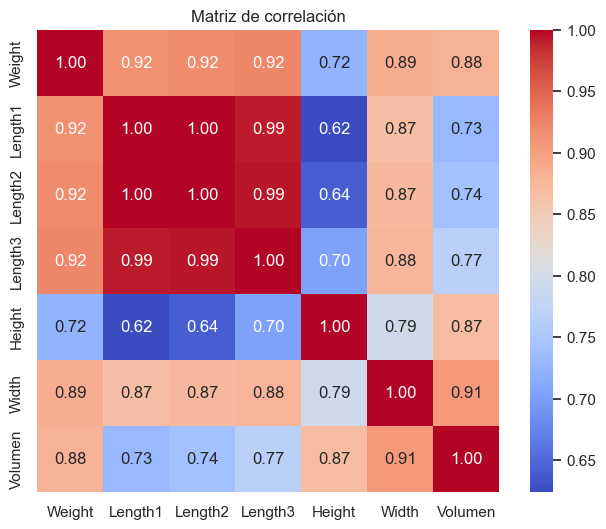

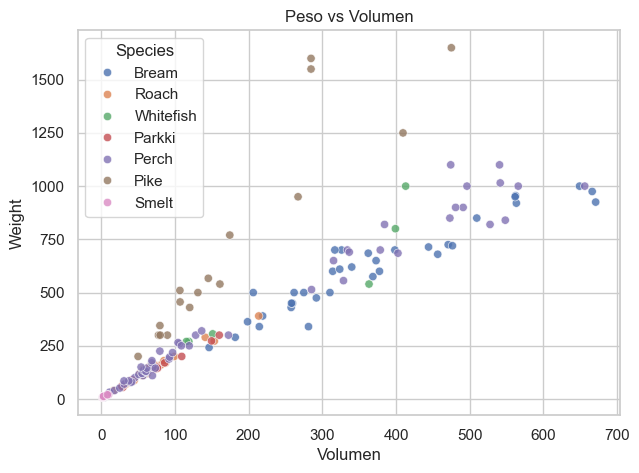

In [12]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df[["Weight","Length1","Length2","Length3","Height","Width","Volumen"]].corr(),
    annot=True, fmt=".2f", cmap="coolwarm", square=True
)
plt.title("Matriz de correlación")
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="Volumen", y="Weight", hue="Species", alpha=0.8)
plt.title("Peso vs Volumen")
plt.show()


### Observación
Al incluir `Volumen`, la correlación con `Weight` aumenta significativamente (cercana a 1).  
Esto indica que `Volumen` combina mejor la información de `Height` y `Width` para explicar el peso.


## Modelo simple entre Weight ~ Volumen

In [24]:
X = df[["Volumen"]].values
y = df["Weight"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin = LinearRegression()
lin.fit(X_train, y_train)

y_pred_train = lin.predict(X_train)
y_pred_test = lin.predict(X_test)

print("Coeficiente:", lin.coef_[0])
print("Intercepto:", lin.intercept_)

_ = evaluar_modelo(y_train, y_pred_train, prefix="Train")
_ = evaluar_modelo(y_test, y_pred_test, prefix="Test")


Coeficiente: 1.7535275765398137
Intercepto: 56.200380768049115
[Train] R2 = 0.7595 | RMSE = 173.136
[Test] R2 = 0.8378 | RMSE = 147.556


## Gráfico del modelo simple

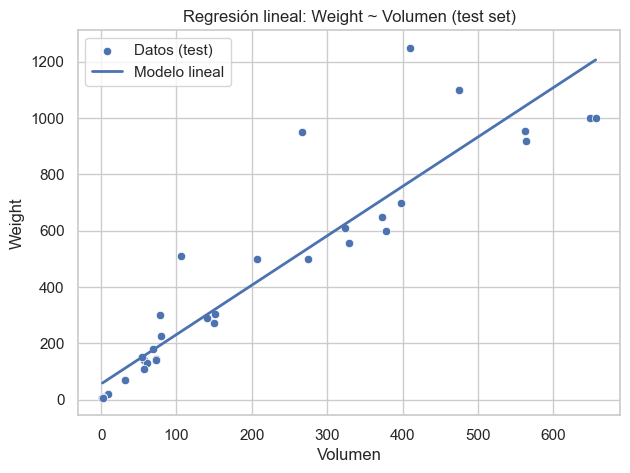

In [26]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_test.flatten(), y=y_test, label="Datos (test)")
order = np.argsort(X_test.flatten())
plt.plot(X_test.flatten()[order], y_pred_test[order], lw=2, label="Modelo lineal")
plt.xlabel("Volumen"); plt.ylabel("Weight")
plt.title("Regresión lineal: Weight ~ Volumen (test set)")
plt.legend()
plt.show()


## Modelo por especie
Hipótesis: al separar por especie, la relación peso-volumen será más precisa (menos variabilidad interna).

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
resultados = []

for sp, g in df.groupby("Species"):
    Xg = g[["Volumen"]].values
    yg = g["Weight"].values
    if len(g) < 5:
        lin_sp = LinearRegression().fit(Xg, yg)
        yhat = lin_sp.predict(Xg)
        met = evaluar_modelo(yg, yhat, prefix=sp)
        resultados.append({"Species": sp, "R2_CVmean": met["R2"], "N": len(g)})
    else:
        scores = cross_val_score(LinearRegression(), Xg, yg, cv=kf, scoring="r2")
        resultados.append({"Species": sp, "R2_CVmean": scores.mean(), "N": len(g)})

pd.DataFrame(resultados).sort_values("R2_CVmean", ascending=False).reset_index(drop=True)


C:\Users\Moonlab\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Moonlab\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Moonlab\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Moonlab\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


,Species,R2_CVmean,N
0,Perch,0.962729,56
1,Roach,0.931790,19
2,Bream,0.884798,35
3,Parkki,0.689231,11
4,Pike,0.623030,17
5,Smelt,-7.898458,14
6,Whitefish,NaN,6


## Modelo multivariable
Probamos un modelo con varias variables predictoras:  
`Weight ~ Length2 + Height + Width + Volumen`


In [29]:
X = df[["Length2","Height","Width","Volumen"]]
y = df["Weight"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_multi = LinearRegression()
lin_multi.fit(X_train, y_train)

y_pred_train = lin_multi.predict(X_train)
y_pred_test = lin_multi.predict(X_test)

_ = evaluar_modelo(y_train, y_pred_train, prefix="Train")
_ = evaluar_modelo(y_test, y_pred_test, prefix="Test")


[Train] R2 = 0.9429 | RMSE = 84.386
[Test] R2 = 0.9741 | RMSE = 58.972


# Conclusiones

- El volumen (`Volumen`) mejora claramente la correlación con el peso respecto a cada dimensión por separado.  
- El modelo simple `Weight ~ Volumen` logra buen ajuste global, aunque con diferencias entre especies.  
- Separando por especie, los modelos muestran mejores métricas (más homogéneos).  
- El modelo multivariable que combina longitudes y `Volumen` presenta el mejor desempeño general, ya que integra más información de las dimensiones del pez.  
